In [16]:
import pandas as pd
import numpy as np
import pickle
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the saved pipeline and data
with open('iag_full_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

# Define features
categorical_features = [
    'iag_business_unit_ug', 'iag_age_band_auto', 'iag_tenure_band_enum',
    'iag_site_ug', 'iag_product_type_auto', 'iag_region_ug'
]
numeric_features = [
    'iag_trust_confidence_scale11', 'iag_value_price_of_policy_reflects_scale11'
]

# Load and prepare data
df = pd.read_excel('IAG.xlsx')
X = df[categorical_features + numeric_features]
y = df['Likely to recommend']

# Remove detract classes and convert to binary
mask = ~y.isin(['Detract', 'Super Detract'])
X = X[mask]
y = (y[mask] == 'Promote').astype(int)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
cat_pipeline = preprocessor.named_transformers_['cat']
onehot = cat_pipeline.named_steps['onehot']
cat_feature_names = onehot.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transform the data
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Create the SHAP explainer
explainer = shap.LinearExplainer(pipeline.named_steps['classifier'], 
                               X_train_transformed,
                               feature_names=feature_names)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# 1. Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names,
                 plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('shap_beeswarm.png')
plt.close()

# 2. Force Plot for first prediction
plt.figure(figsize=(20, 3))
force_plot = shap.force_plot(explainer.expected_value,
                           shap_values[0,:],
                           X_train_transformed[0,:],
                           feature_names=feature_names,
                           matplotlib=True,
                           show=False)
plt.title("SHAP Force Plot for First Prediction")
plt.tight_layout()
plt.savefig('shap_force_plot.png', bbox_inches='tight')
plt.close()

# 3. Waterfall Plot for first prediction
plt.figure(figsize=(10, 12))
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                     shap_values[0,:],
                                     feature_names=feature_names,
                                     show=False)
plt.title("SHAP Waterfall Plot for First Prediction")
plt.tight_layout()
plt.savefig('shap_waterfall.png', bbox_inches='tight')
plt.close()

# Print feature importance summary
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Calculate and print some interpretative statistics
print("\nSHAP Statistics:")
print(f"Average absolute SHAP value: {np.abs(shap_values).mean():.4f}")
print(f"Maximum absolute SHAP value: {np.abs(shap_values).max():.4f}")
print(f"Minimum absolute SHAP value: {np.abs(shap_values).min():.4f}")

# Save SHAP values for future use
np.save('shap_values.npy', shap_values)
print("\nAnalysis complete. SHAP values and visualizations have been saved.")

The figure layout has changed to tight



Top 10 Most Important Features:
                                       feature  importance
0                 iag_trust_confidence_scale11    0.759653
1   iag_value_price_of_policy_reflects_scale11    0.571125
71    iag_product_type_auto_Private Motor Line    0.176285
68       iag_product_type_auto_Homeowners Line    0.149931
9                        iag_age_band_auto_65+    0.095453
75           iag_region_ug_Consumer Claims Ops    0.087554
76         iag_region_ug_Retail Network Claims    0.049144
12                  iag_tenure_band_enum_21-30    0.048595
3              iag_business_unit_ug_Operations    0.037685
55                      iag_site_ug_Home based    0.037497

SHAP Statistics:
Average absolute SHAP value: 0.0316
Maximum absolute SHAP value: 1.4307
Minimum absolute SHAP value: 0.0000

Analysis complete. SHAP values and visualizations have been saved.


The SHAP results align well with the other analyses, but show some interesting nuances:

1. Policy Value/Price:
- High importance in both permutation method (2nd highest) and SHAP analysis
- Decision tree uses it as the primary split (<=4.5)
- SHAP shows it has the strongest negative impact (-0.77), meaning lower price satisfaction strongly decreases likelihood of recommendation
- This consistent prominence across methods validates its crucial role

2. Trust/Confidence:
- Highest in permutation importance
- Strong positive SHAP value (+0.45)
- Not prominent in decision tree
- This suggests it has a strong linear relationship with recommendations that might not be captured well by tree-based splitting

3. Product Type:
- Low importance in permutation method
- Appears in decision tree for final classifications
- Moderate SHAP impact (+0.17 for Private Motor Line)
- Shows how different methods can capture different aspects of feature importance

The policy value's behavior in SHAP adds valuable context to the permutation results by showing the directionality and magnitude of its impact, revealing that poor price perception has a stronger negative effect than good price perception has a positive effect.


Why is private motor line specifically pushing it up? its not a feature right, its a category within the feature product type. and what does pushing up and pushing down the prediction mean?

Product type is indeed a categorical feature, and "Private Motor Line" is one of its categories. The SHAP values show that when a customer has Private Motor Line (vs other product types), it increases the probability of them being a "Promoter" (more likely to recommend).

The prediction values refer to log-odds in logistic regression:
- Higher values (pushing up) = more likely to be a Promoter
- Lower values (pushing down) = less likely to be a Promoter

For this specific customer:
- Having Private Motor Line product (+0.17) increases their likelihood of being a Promoter
- Low price satisfaction (-0.77) strongly decreases their likelihood 
- High trust (+0.45) increases their likelihood

The final prediction (1.534) represents this customer's probability of being a Promoter after combining all these effects.

Random Sample:


<Figure size 1200x300 with 0 Axes>

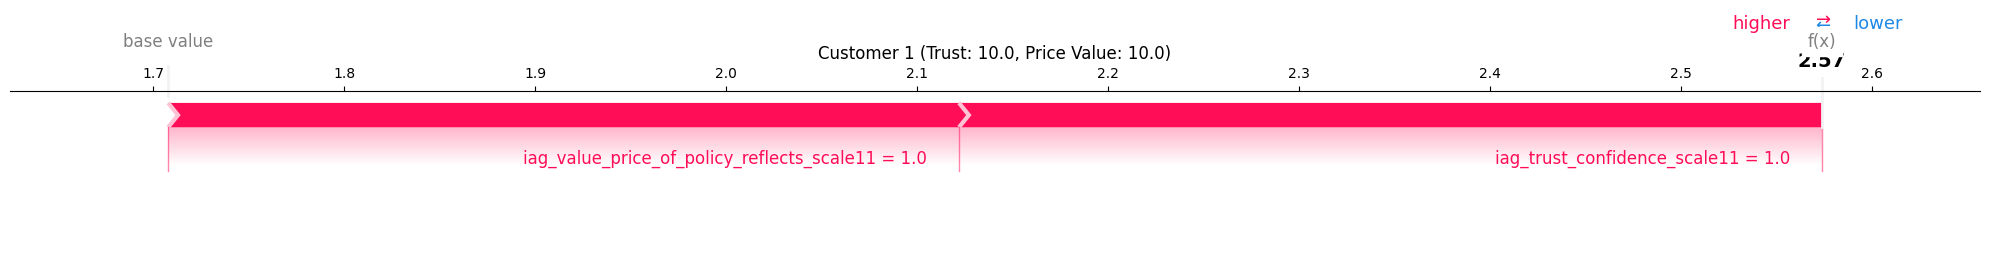

<Figure size 1200x300 with 0 Axes>

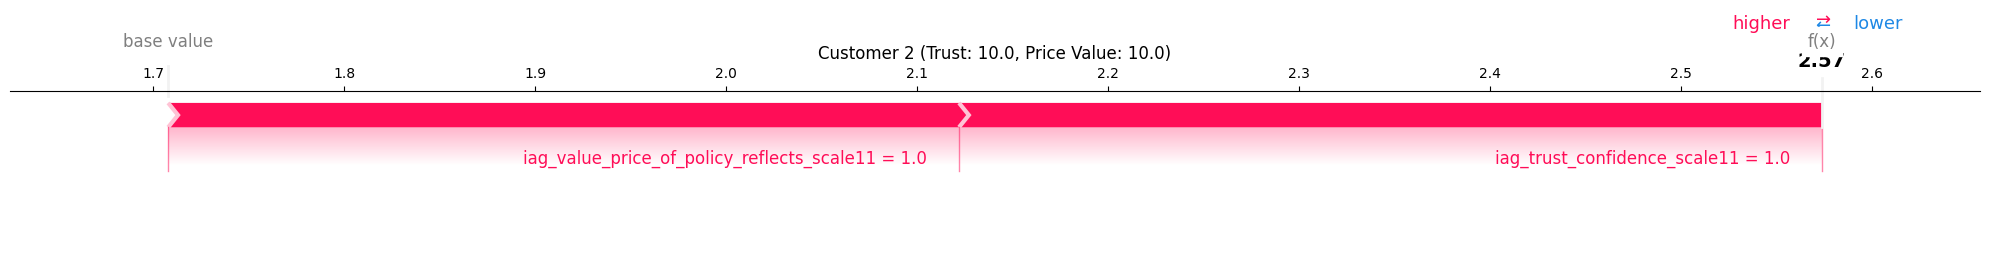

divide by zero encountered in scalar divide


<Figure size 1200x300 with 0 Axes>

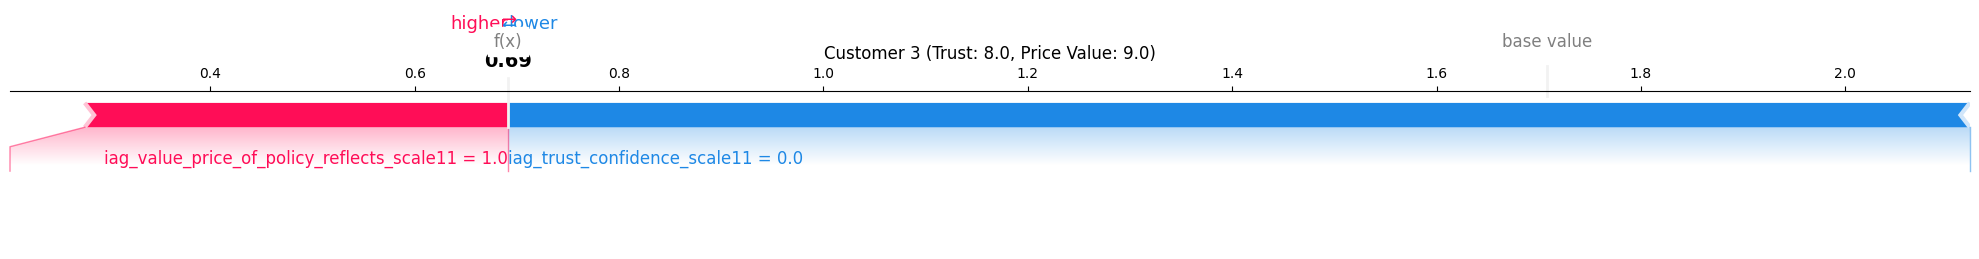


High Trust Customers:


<Figure size 1200x300 with 0 Axes>

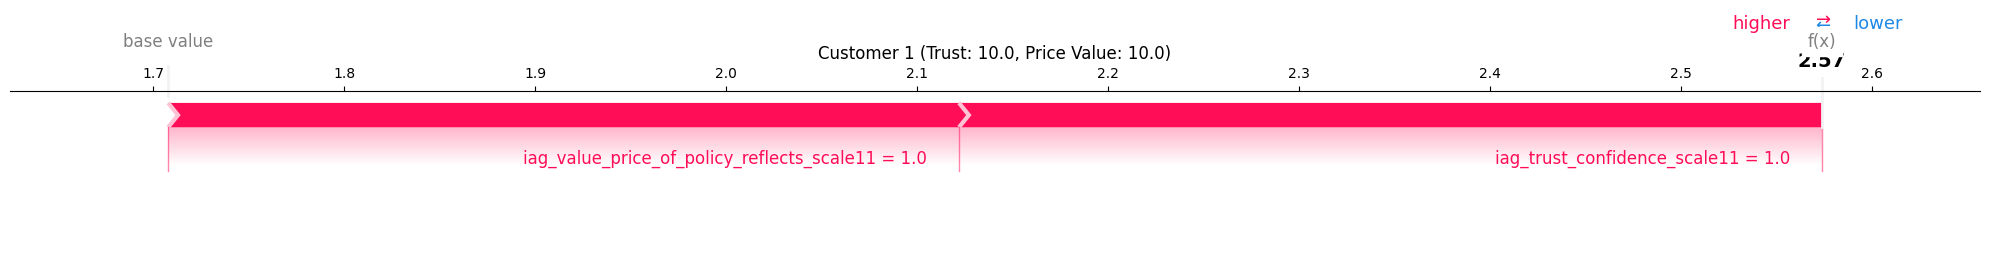

<Figure size 1200x300 with 0 Axes>

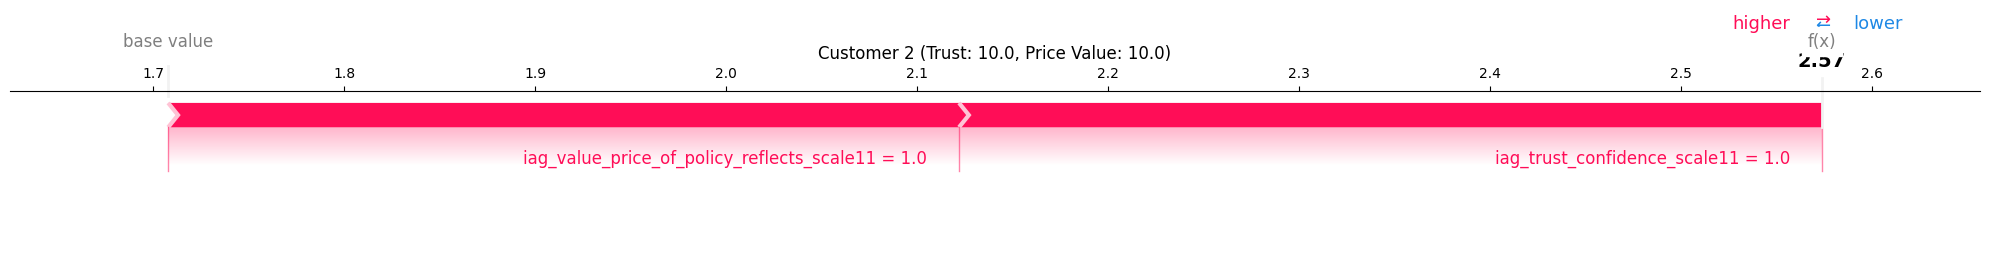

<Figure size 1200x300 with 0 Axes>

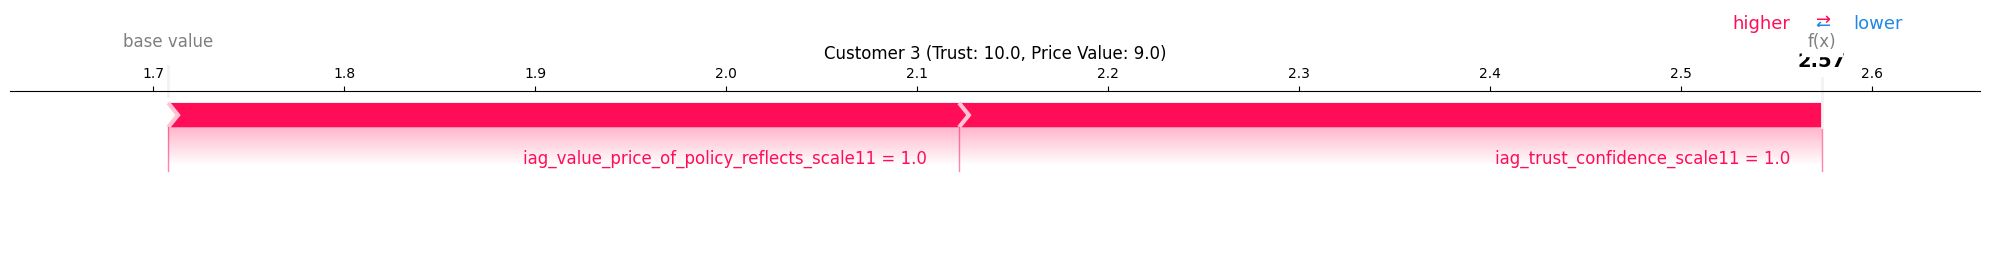


Low Trust Customers:


divide by zero encountered in scalar divide


<Figure size 1200x300 with 0 Axes>

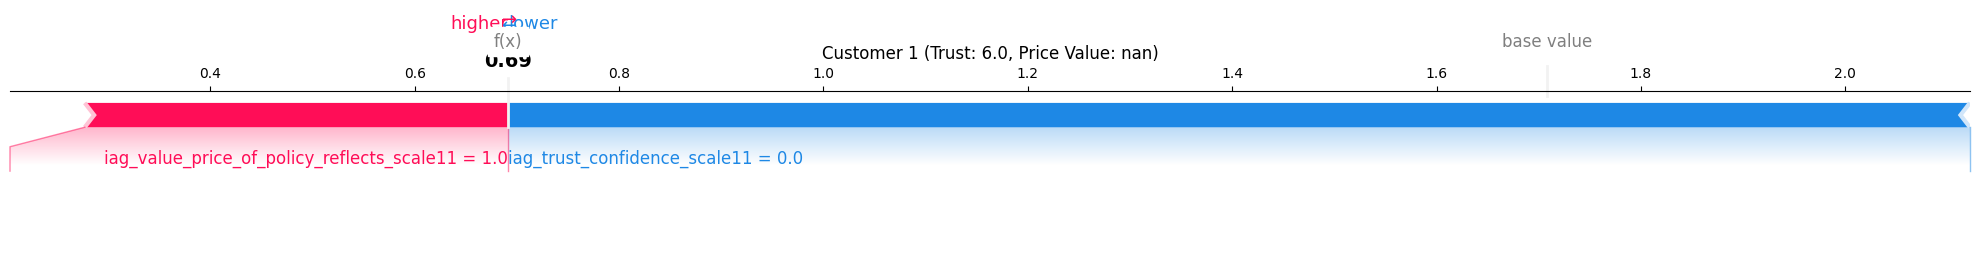

<Figure size 1200x300 with 0 Axes>

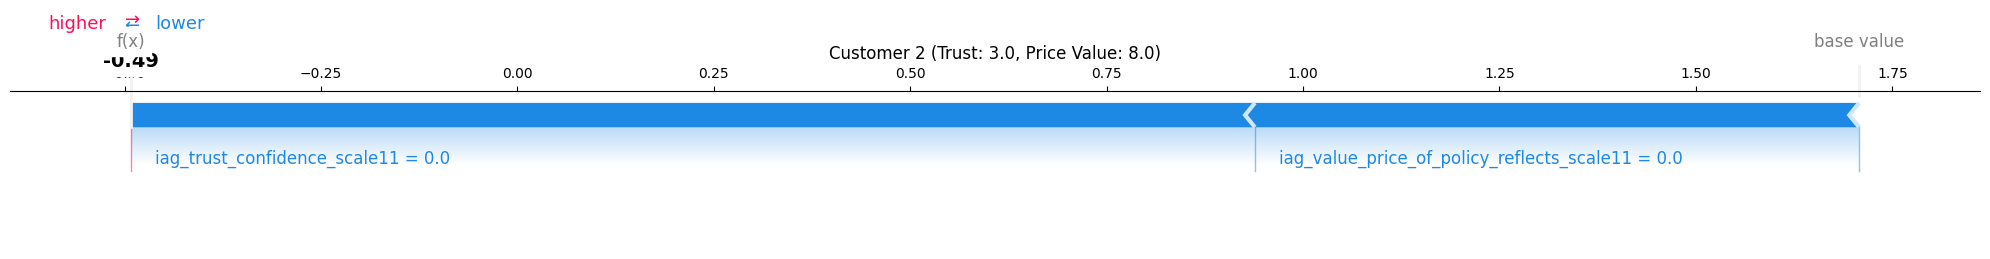

<Figure size 1200x300 with 0 Axes>

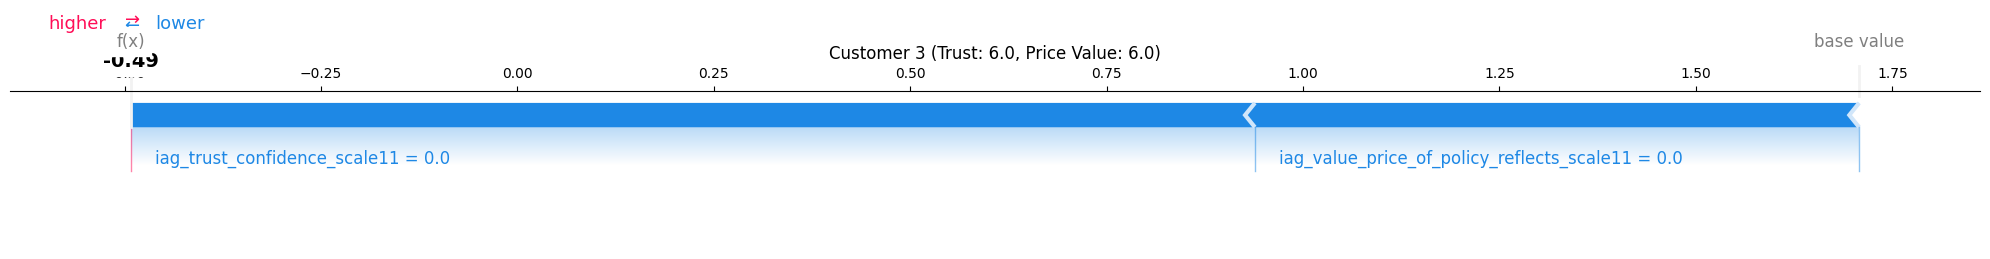

In [10]:
import shap
import matplotlib.pyplot as plt
%matplotlib inline

def analyze_customers(X_sample, n_display=3):
    X_transformed = pipeline.named_steps['preprocessor'].transform(X_sample)
    explainer = shap.LinearExplainer(
        pipeline.named_steps['classifier'],
        pipeline.named_steps['preprocessor'].transform(X_train)
    )
    shap_values = explainer.shap_values(X_transformed)
    
    for i in range(min(n_display, len(X_sample))):
        plt.figure(figsize=(12, 3))
        shap.force_plot(
            explainer.expected_value,
            shap_values[i],
            X_transformed[i],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"Customer {i+1} (Trust: {X_sample.iloc[i]['iag_trust_confidence_scale11']}, "
                 f"Price Value: {X_sample.iloc[i]['iag_value_price_of_policy_reflects_scale11']})")
        plt.tight_layout()
        plt.show()

# Analyze different segments
print("Random Sample:")
random_indices = np.random.choice(len(X), 3, replace=False)
analyze_customers(X.iloc[random_indices])

print("\nHigh Trust Customers:")
high_trust = X[X['iag_trust_confidence_scale11'] > 8]
analyze_customers(high_trust.sample(3))

print("\nLow Trust Customers:")
low_trust = X[X['iag_trust_confidence_scale11'] <= 6]
analyze_customers(low_trust.sample(3))

<Figure size 1500x400 with 0 Axes>

<Figure size 1500x400 with 0 Axes>

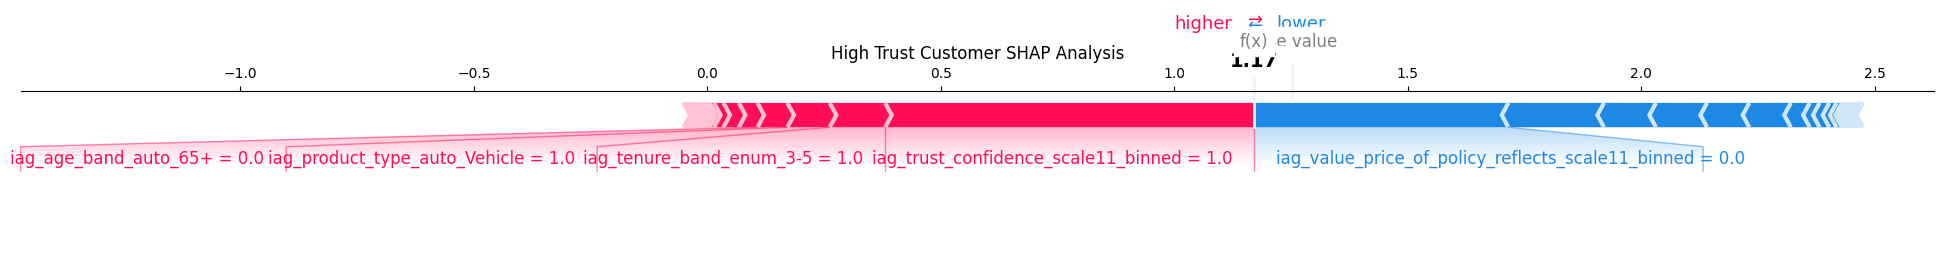


Top 5 feature contributions:
                                              feature  importance
0                 iag_trust_confidence_scale11_binned    0.790637
1   iag_value_price_of_policy_reflects_scale11_binned    0.544235
71           iag_product_type_auto_Private Motor Line    0.204820
13                           iag_tenure_band_enum_3-5    0.118627
68              iag_product_type_auto_Homeowners Line    0.111398


In [15]:
import shap
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

# Load data and pipeline
df = pd.read_excel('IAG.xlsx')
with open('iag_full_pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

# Define features
categorical_features = [
    'iag_business_unit_ug', 'iag_age_band_auto', 'iag_tenure_band_enum',
    'iag_site_ug', 'iag_product_type_auto', 'iag_region_ug'
]
numeric_features = [
    'iag_trust_confidence_scale11', 'iag_value_price_of_policy_reflects_scale11'
]

X = df[categorical_features + numeric_features]

# Transform full dataset first for background distribution
X_full_transformed = pipeline.named_steps['preprocessor'].transform(X)

# Select and transform high trust customer
high_trust_customer = X[df['iag_trust_confidence_scale11'] > 8].iloc[0:1]
customer_transformed = pipeline.named_steps['preprocessor'].transform(high_trust_customer)

# Get feature names
num_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']
cat_transformer = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names = (
    [f"{feat}_binned" for feat in numeric_features] +
    [f"{feat}_{val}" for feat, vals in zip(categorical_features, 
                                         cat_transformer.named_steps['onehot'].categories_)
     for val in vals]
)

# Create explainer using full transformed dataset
classifier = pipeline.named_steps['classifier']
explainer = shap.LinearExplainer(classifier, X_full_transformed)
shap_values = explainer.shap_values(customer_transformed)

# Plot
plt.figure(figsize=(15, 4))
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    customer_transformed[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title("High Trust Customer SHAP Analysis")
plt.tight_layout()
plt.show()

# Print feature contributions
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values[0])
}).sort_values('importance', ascending=False)

print("\nTop 5 feature contributions:")
print(importance.head())